# FFDI Statistics

code is setup to compute some statistics from the Zarr store of the RCM ffdi data which has been been according to GWl


In [1]:
import sys
import os

import intake
import xarray as xr
from matplotlib import pyplot as plt
import glob
import pathlib
import traceback
from datetime import datetime
from xclim.indices import (
    keetch_byram_drought_index,
    griffiths_drought_factor,
    mcarthur_forest_fire_danger_index
)
from dask.distributed import Client

# Needed for the GWL code
from importlib import reload
# adding folder to the system path
sys.path.insert(0, '/g/data/xv83/rxm599/acs/gwls')

import gwl

In [2]:
# Start Cluster 
import dask
# Set configuration options
dask.config.set({
    'distributed.comm.timeouts.connect': '90s',  # Timeout for connecting to a worker
    'distributed.comm.timeouts.tcp': '90s',  # Timeout for TCP communications
})

import warnings
warnings.filterwarnings('ignore')
client = Client()
client

2024-07-26 18:34:19,556 - distributed.preloading - INFO - Creating preload: /g/data/hh5/public/apps/dask-optimiser/schedplugin.py
2024-07-26 18:34:19,559 - distributed.utils - INFO - Reload module schedplugin from .py file
2024-07-26 18:34:19,583 - distributed.preloading - INFO - Import preload module: /g/data/hh5/public/apps/dask-optimiser/schedplugin.py


Modifying workers


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /node/gadi-mmem-clx-0001.gadi.nci.org.au/26699/proxy/8787/status,
Dashboard: /node/gadi-mmem-clx-0001.gadi.nci.org.au/26699/proxy/8787/status,Workers: 48
Total threads: 48,Total memory: 0 B
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40041,Workers: 48
Dashboard: /node/gadi-mmem-clx-0001.gadi.nci.org.au/26699/proxy/8787/status,Total threads: 48
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:37297,Total threads: 1
Dashboard: /node/gadi-mmem-clx-0001.gadi.nci.org.au/26699/proxy/42083/status,Memory: 0 B
Nanny: tcp://127.0.0.1:34945,


In [4]:
catalogue_path = '/g/data/ia39/ncra/fire/ffdi/'
mRuns = sorted(glob.glob(catalogue_path + '*GWL3*.zarr'))
print(len(mRuns))

12


In [53]:
#rm tmp.nc
for mindex, file in enumerate(mRuns):
    print(mindex,file)
    ds=xr.open_zarr( file ) 
    mm=ds.groupby('time.month').max('time').persist()
#m1=mm.FFDI.sel(month=1).plot()
    fout=f'/scratch/xv83/rxm599/model{mindex}.nc'
    mm.FFDI.to_netcdf(fout)

0 /g/data/ia39/ncra/fire/ffdi/AGCD-05i_BOM_ACCESS-CM2_ssp370_r4i1p1f1_BARPA-R_v1-r1_day_GWL3.0_ffdi.zarr
1 /g/data/ia39/ncra/fire/ffdi/AGCD-05i_BOM_CESM2_ssp370_r11i1p1f1_BARPA-R_v1-r1_day_GWL3.0_ffdi.zarr
2 /g/data/ia39/ncra/fire/ffdi/AGCD-05i_BOM_CMCC-ESM2_ssp370_r1i1p1f1_BARPA-R_v1-r1_day_GWL3.0_ffdi.zarr
3 /g/data/ia39/ncra/fire/ffdi/AGCD-05i_BOM_EC-Earth3_ssp370_r1i1p1f1_BARPA-R_v1-r1_day_GWL3.0_ffdi.zarr
4 /g/data/ia39/ncra/fire/ffdi/AGCD-05i_BOM_MPI-ESM1-2-HR_ssp370_r1i1p1f1_BARPA-R_v1-r1_day_GWL3.0_ffdi.zarr
5 /g/data/ia39/ncra/fire/ffdi/AGCD-05i_BOM_NorESM2-MM_ssp370_r1i1p1f1_BARPA-R_v1-r1_day_GWL3.0_ffdi.zarr
6 /g/data/ia39/ncra/fire/ffdi/AGCD-05i_CSIRO_ACCESS-CM2_ssp370_r4i1p1f1_CCAM-v2203-SN_v1-r1_day_GWL3.0_ffdi.zarr
7 /g/data/ia39/ncra/fire/ffdi/AGCD-05i_CSIRO_ACCESS-ESM1-5_ssp370_r6i1p1f1_CCAM-v2203-SN_v1-r1_day_GWL3.0_ffdi.zarr
8 /g/data/ia39/ncra/fire/ffdi/AGCD-05i_CSIRO_CESM2_ssp370_r11i1p1f1_CCAM-v2203-SN_v1-r1_day_GWL3.0_ffdi.zarr
9 /g/data/ia39/ncra/fire/ffdi/AGCD-

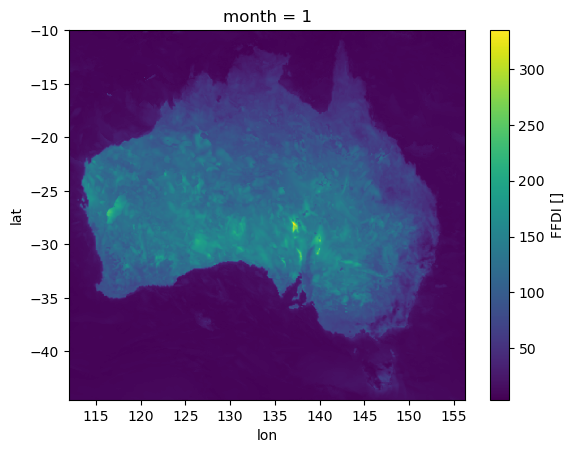

In [54]:
m1=mm.FFDI.sel(month=1).plot()

In [77]:
dss=xr.open_mfdataset('/scratch/xv83/rxm599/model*.nc',combine='nested',
        concat_dim=[ "model" ] )
#ds=xr.open_mfdataset('/scratch/xv83/rxm599/model*.nc',concat_dims='model')

In [78]:
dss

<xarray.Dataset> Size: 705MB
Dimensions:  (lat: 691, lon: 886, month: 12, model: 12)
Coordinates:
  * lat      (lat) float64 6kB -44.5 -44.45 -44.4 -44.35 ... -10.1 -10.05 -10.0
  * lon      (lon) float64 7kB 112.0 112.0 112.1 112.2 ... 156.2 156.2 156.2
  * month    (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: model
Data variables:
    FFDI     (model, month, lat, lon) float64 705MB dask.array<chunksize=(1, 12, 691, 886), meta=np.ndarray>

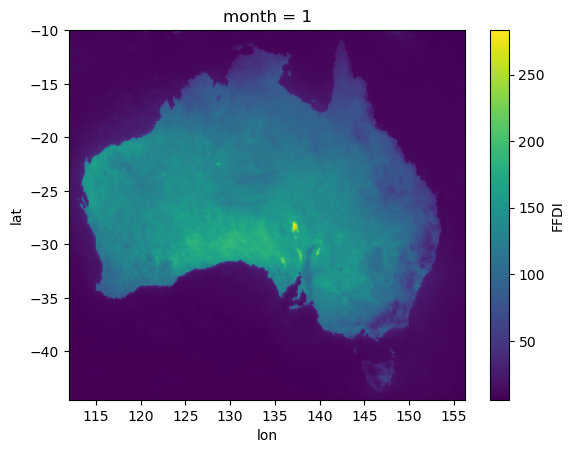

In [88]:
plt.subplot(1,1,1); dss.FFDI.sel(month=1).mean('model').plot()
#plt.subplot(2,1,2) ; dss.FFDI.sel(month=1).max('model').plot()

In [3]:
client.close()